<a href="https://colab.research.google.com/github/danyentezari/bn-ocr/blob/main/keras_ocr_bignumber_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras==2.2.5
!pip install tensorflow==1.13.1
# !unzip kaggle.json.zip
# !mkdir ~/.kaggle 
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download scolianni/mnistasjpg
# !unzip mnistasjpg.zip
!pip install 'h5py==2.10.0' --force-reinstall
!pip install cairocffi
!pip install gdown
!pip install synthtiger

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!git clone https://github.com/clovaai/synthtiger.git

fatal: destination path 'synthtiger' already exists and is not an empty directory.


In [3]:
!cp -r synthtiger/* .

In [ ]:
!synthtiger -o results -w 4 -v examples/synthtiger/template.py SynthTiger examples/synthtiger/config_horizontal.yaml

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import re
from scipy.sparse import csr_matrix
import cv2
import string
from PIL import Image

import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D # convolution layers
from keras.layers import Dense, Dropout, Flatten # core layers
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Add
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

import matplotlib.pyplot as plt
%matplotlib inline


In [171]:
def loadImage(filepath):
  img = load_img(filepath)
  img = img_to_array(img)
  #img = img.reshape(1, 42, 42, 3)
  # img = img.reshape(64, 192, 3)
  img = img.astype('float32')
  # img = img / 255.0
  return img

### Features and Labels

In [206]:
def create_canvas(canvas_h=300, canvas_w=300):
  # Create canvas
  canvas_color = 255

  pixel_rows = []
  row = [canvas_color for x in range(0,canvas_w)]
  for i in range(0,canvas_h):
    pixel_rows.append(row)
  r = pixel_rows
  g = pixel_rows
  b = pixel_rows

  canvas = np.dstack((r,g,b))
  return canvas

cw = 950
ch = 200
canvas = create_canvas(ch, cw)

def center_pad_image(img, canvas_h=300, canvas_w=300):
  # Image positions
  img2_width = img.shape[1]
  img2_height = img.shape[0]
  black_row = np.array([[0 for x in range(0,img2_width)]])
  img2 = np.dstack((black_row,black_row,black_row))


  startx = int((canvas_w-img2_width)/2)
  starty = int((canvas_h-img2_height)/2)
  endx = startx + img2_width
  endy = starty + img2_height

  # Superimpose image
  to_superimpose = Image.fromarray(np.uint8(img)).convert('RGB')
  # Reset global canvas
  canvas[:, :] = 255
  canvas[starty:endy, startx:endx] = to_superimpose


  return Image.fromarray(np.uint8(canvas)).convert('RGB')


# center_pad_image(sample_image, ch, cw)

100
(90, 462, 3)


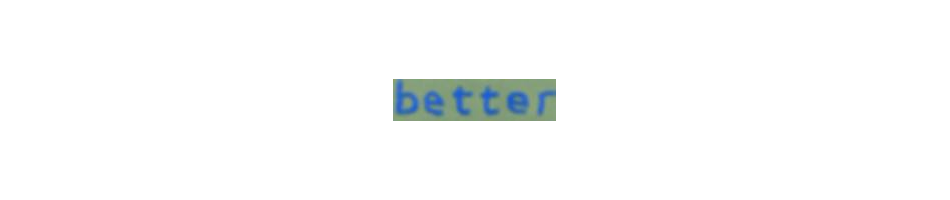

In [210]:
import re
file1 = open('./results/gt.txt', 'r')
Lines = file1.readlines()
  
print(len(Lines))

data_F = np.empty((100, ch, cw, 3))
data_L = np.array([])

count = 0
# Strips the newline character
for i,line in enumerate(Lines):
    d = re.split('\t', line)
    d[1] = d[1].replace('\n','')

    img = loadImage(f'results/{d[0]}')
    loaded_image = np.array(center_pad_image(img, ch, cw))
    data_F[i] = loaded_image
    data_L = np.append(data_L, d[1])

print(img.shape)
data_F.shape
Image.fromarray(np.uint8(data_F[0])).convert('RGB')

THE
(200, 950, 3)
(90, 462, 3)


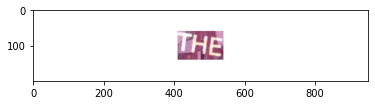

In [211]:
# img = data_F[0]
# img = img.astype(np.uint8) 
# plt.title(data_L[0])
x = data_F[90].astype(np.uint8)
plt.imshow(x)

print(data_L[90])
print(x.shape)
print(img.shape)

In [258]:
alphabet = 'abcdefghijklmnopqrstuvwxyz./:;,\'"-_1234567890?!)(][}{><'
alph_num = re.split('', alphabet)
alph_dict = dict({})

for j, c in enumerate(alph_num):
  alph_dict[c] = j

In [224]:
s = 'better'
alph_dict
_id = list(map(lambda c: alph_dict[c], s))
_id
# data_L_dist = to_categorical(data_L[0])

[2, 5, 20, 20, 5, 18]

In [286]:
m = lambda x: [alph_dict[c] for c in x]

data_L_id = np.zeros((100,50))
for k,data in enumerate(data_L):
  data = data.lower()
  ids = m(data)
  # data_L_id = np.append(data_L_id, [ids], axis=0)
  data_L_id[k][0:len(ids)] = ids[:]
  # data_L_id = np.append(data_L_id, m(data), axis=0)

In [289]:
data_L_dist = to_categorical(data_L_id)

In [291]:
data_L_dist.shape

(100, 50, 55)

In [292]:
len(alphabet)

55

### Model

In [ ]:
train_F, test_F, train_L_dist, test_L_dist = train_test_split(data_F, data_L_dist, test_size=0.1, random_state=0)

In [ ]:
train_F.shape, test_F.shape, train_L_dist.shape, test_L_dist.shape

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(train_F, train_L_dist, batch_size=128)
test_gen = datagen.flow(test_F, test_L_dist, batch_size=128)

In [ ]:
epochs = 5
batch_size = 128
train_steps = train_F.shape[0] // batch_size
valid_steps = train_L_dist.shape[0] // batch_size

es = keras.callbacks.EarlyStopping(
        monitor="val_acc", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [ ]:
img_w = 512
img_h = 64
words_per_epoch = 16000
val_split = 0.2
val_words = int(words_per_epoch * (val_split))

# Network parameters
conv_filters = 16
kernel_size = (3, 3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
minibatch_size = 32

# model1=Sequential()

# #model1.add(Lambda(standardize,input_shape=(28,28,1)))    
# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal', input_shape=(28,28,3)))

# model1.add(MaxPooling2D(pool_size=(2,2)))

# model1.add(Conv2D(filters=conv_filters, kernel_size = (3,3), activation="relu", kernel_initializer='he_normal'))

# model1.add(MaxPooling2D(pool_size=(2,2)))


# # conv_to_rnn_dims = (img_w // (pool_size ** 2),
# #                     (img_h // (pool_size ** 2)) * conv_filters)


# # model1.add(Reshape(target_shape=conv_to_rnn_dims))

# model1.add(Flatten())

# model1.add(Dense(time_dense_size, activation='relu'))


# gru1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')
# gru2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', go_backwards=True)
# gru_merged = Add()([gru1, gru2]) #add([gru1, gru2])
# model1.add(gru_merged)

# gru1b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal')
# gru2b = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', go_backwards=True)
# gru2b_concat = concatenate(gru1b, gru2b)
# model1.add(gru2b_concat)

# model1.add(Dense(20, activation='softmax', kernel_initializer='he_normal'))
# model1.add()

input_shape = (None, None, 3)

act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
                activation=act, kernel_initializer='he_normal',
                name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2),
                    (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Two layers of bidirectional GRUs
# GRU seems to work as well, if not better than LSTM:
gru_1 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True,
              go_backwards=True, kernel_initializer='he_normal',
              name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True,
              kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(20, kernel_initializer='he_normal', name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = inner#Activation('softmax', name='softmax')(inner)

prediction_model = Model(inputs=input_data, outputs=y_pred)
prediction_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
prediction_model.summary()

In [ ]:
import os
import itertools
import codecs
import re
import datetime
import cairocffi as cairo
import editdistance
import numpy as np
from scipy import ndimage
import pylab
import tensorflow
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
#from keras.metrics import Metric
from tensorflow.python.keras.metrics import Metric

OUTPUT_DIR = 'image_ocr'

# character classes and matching regex filter
regex = r'^[a-z ]+$'
alphabet = u'abcdefghijklmnopqrstuvwxyz '

np.random.seed(55)


# this creates larger "blotches" of noise which look
# more realistic than just adding gaussian noise
# assumes greyscale with pixels ranging from 0 to 1

def speckle(img):
  severity = np.random.uniform(0, 0.6)
  blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
  img_speck = (img + blur)
  img_speck[img_speck > 1] = 1
  img_speck[img_speck <= 0] = 0
  return img_speck


# paints the string in a random location the bounding box
# also uses a random font, a slight random rotation,
# and a random amount of speckle noise

def paint_text(text, w, h, rotate=False, ud=False, multi_fonts=False):
  surface = cairo.ImageSurface(cairo.FORMAT_RGB24, w, h)
  with cairo.Context(surface) as context:
      context.set_source_rgb(1, 1, 1)  # White
      context.paint()
      # this font list works in CentOS 7
      if multi_fonts:
          fonts = [
              'Century Schoolbook', 'Courier', 'STIX',
              'URW Chancery L', 'FreeMono']
          context.select_font_face(
              np.random.choice(fonts),
              cairo.FONT_SLANT_NORMAL,
              np.random.choice([cairo.FONT_WEIGHT_BOLD, cairo.FONT_WEIGHT_NORMAL]))
      else:
          context.select_font_face('Courier',
                                    cairo.FONT_SLANT_NORMAL,
                                    cairo.FONT_WEIGHT_BOLD)
      context.set_font_size(25)
      box = context.text_extents(text)
      border_w_h = (4, 4)
      if box[2] > (w - 2 * border_w_h[1]) or box[3] > (h - 2 * border_w_h[0]):
          raise IOError(('Could not fit string into image.'
                          'Max char count is too large for given image width.'))

      # teach the RNN translational invariance by
      # fitting text box randomly on canvas, with some room to rotate
      max_shift_x = w - box[2] - border_w_h[0]
      max_shift_y = h - box[3] - border_w_h[1]
      top_left_x = np.random.randint(0, int(max_shift_x))
      if ud:
          top_left_y = np.random.randint(0, int(max_shift_y))
      else:
          top_left_y = h // 2
      context.move_to(top_left_x - int(box[0]), top_left_y - int(box[1]))
      context.set_source_rgb(0, 0, 0)
      context.show_text(text)

  buf = surface.get_data()
  a = np.frombuffer(buf, np.uint8)
  a.shape = (h, w, 4)
  a = a[:, :, 0]  # grab single channel
  a = a.astype(np.float32) / 255
  a = np.expand_dims(a, 0)
  if rotate:
      a = image.random_rotation(a, 3 * (w - top_left_x) / w + 1)
  a = speckle(a)

  return a


def shuffle_mats_or_lists(matrix_list, stop_ind=None):
  ret = []
  assert all([len(i) == len(matrix_list[0]) for i in matrix_list])
  len_val = len(matrix_list[0])
  if stop_ind is None:
      stop_ind = len_val
  assert stop_ind <= len_val

  a = list(range(stop_ind))
  np.random.shuffle(a)
  a += list(range(stop_ind, len_val))
  for mat in matrix_list:
      if isinstance(mat, np.ndarray):
          ret.append(mat[a])
      elif isinstance(mat, list):
          ret.append([mat[i] for i in a])
      else:
          raise TypeError('`shuffle_mats_or_lists` only supports '
                          'numpy.array and list objects.')
  return ret


# Translation of characters to unique integer values
def text_to_labels(text):
  ret = []
  for char in text:
      ret.append(alphabet.find(char))
  return ret


# Reverse translation of numerical classes back to characters
def labels_to_text(labels):
  ret = []
  for c in labels:
      if c == len(alphabet):  # CTC Blank
          ret.append("")
      else:
          ret.append(alphabet[c])
  return "".join(ret)


# only a-z and space..probably not to difficult
# to expand to uppercase and symbols

def is_valid_str(in_str):
  search = re.compile(regex, re.UNICODE).search
  return bool(search(in_str))


# Uses generator functions to supply train/test with
# data. Image renderings and text are created on the fly
# each time with random perturbations

class TextImageGenerator(keras.callbacks.Callback):

  def __init__(self, monogram_file, bigram_file, minibatch_size,
                img_w, img_h, downsample_factor, val_split,
                absolute_max_string_len=16):

      self.minibatch_size = minibatch_size
      self.img_w = img_w
      self.img_h = img_h
      self.monogram_file = monogram_file
      self.bigram_file = bigram_file
      self.downsample_factor = downsample_factor
      self.val_split = val_split
      self.blank_label = self.get_output_size() - 1
      self.absolute_max_string_len = absolute_max_string_len

      # Dany
      self.cur_val_index = 0
      self.paint_func = lambda text: paint_text(
          text, self.img_w, self.img_h,
          rotate=False, ud=False, multi_fonts=False)
      self.X_text = []
      self.train_started = False

  def get_output_size(self):
      return len(alphabet) + 1

  # num_words can be independent of the epoch size due to the use of generators
  # as max_string_len grows, num_words can grow
  def build_word_list(self, num_words, max_string_len=None, mono_fraction=0.5):
      assert max_string_len <= self.absolute_max_string_len
      assert num_words % self.minibatch_size == 0
      assert (self.val_split * num_words) % self.minibatch_size == 0
      self.num_words = num_words
      self.string_list = [''] * self.num_words
      tmp_string_list = []
      self.max_string_len = max_string_len
      self.Y_data = np.ones([self.num_words, self.absolute_max_string_len]) * -1
      self.X_text = []
      self.Y_len = [0] * self.num_words

      def _is_length_of_word_valid(word):
          return (max_string_len == -1 or
                  max_string_len is None or
                  len(word) <= max_string_len)

      # monogram file is sorted by frequency in english speech
      with codecs.open(self.monogram_file, mode='r', encoding='utf-8') as f:
          for line in f:
              if len(tmp_string_list) == int(self.num_words * mono_fraction):
                  break
              word = line.rstrip()
              if _is_length_of_word_valid(word):
                  tmp_string_list.append(word)

      # bigram file contains common word pairings in english speech
      with codecs.open(self.bigram_file, mode='r', encoding='utf-8') as f:
          lines = f.readlines()
          for line in lines:
              if len(tmp_string_list) == self.num_words:
                  break
              columns = line.lower().split()
              word = columns[0] + ' ' + columns[1]
              if is_valid_str(word) and _is_length_of_word_valid(word):
                  tmp_string_list.append(word)
      if len(tmp_string_list) != self.num_words:
          raise IOError('Could not pull enough words'
                        'from supplied monogram and bigram files.')
      # interlace to mix up the easy and hard words
      self.string_list[::2] = tmp_string_list[:self.num_words // 2]
      self.string_list[1::2] = tmp_string_list[self.num_words // 2:]

      for i, word in enumerate(self.string_list):
          self.Y_len[i] = len(word)
          self.Y_data[i, 0:len(word)] = text_to_labels(word)

          if(i == 5):
            print("Y...", self.Y_data[i, 0:len(word)])
            
            # for j in range(15):
            #   print(self.Y_data[j])

            # print('self.Y_data')
            # print(self.Y_data)
            print(len(self.Y_data))
            # print(word)


          self.X_text.append(word)
      self.Y_len = np.expand_dims(np.array(self.Y_len), 1)

      self.cur_val_index = self.val_split
      self.cur_train_index = 0

  # each time an image is requested from train/val/test, a new random
  # painting of the text is performed
  def get_batch(self, index, size, train):
      # width and height are backwards from typical Keras convention
      # because width is the time dimension when it gets fed into the RNN
      if K.image_data_format() == 'channels_first':
          X_data = np.ones([size, 1, self.img_w, self.img_h])
      else:
          X_data = np.ones([size, self.img_w, self.img_h, 1])

      labels = np.ones([size, self.absolute_max_string_len])
      input_length = np.zeros([size, 1])
      label_length = np.zeros([size, 1])
      source_str = []
      for i in range(size):
          # Mix in some blank inputs.  This seems to be important for
          # achieving translational invariance
          if train and i > size - 4:
              if K.image_data_format() == 'channels_first':
                  X_data[i, 0, 0:self.img_w, :] = self.paint_func('')[0, :, :].T
              else:
                  X_data[i, 0:self.img_w, :, 0] = self.paint_func('',)[0, :, :].T
              labels[i, 0] = self.blank_label
              input_length[i] = self.img_w // self.downsample_factor - 2
              label_length[i] = 1
              source_str.append('')
          else:
              if K.image_data_format() == 'channels_first':
                  X_data[i, 0, 0:self.img_w, :] = (
                      self.paint_func(self.X_text[index + i])[0, :, :].T)
              else:
                  X_data[i, 0:self.img_w, :, 0] = (
                      self.paint_func(self.X_text[index + i])[0, :, :].T)
              labels[i, :] = self.Y_data[index + i]
              input_length[i] = self.img_w // self.downsample_factor - 2
              label_length[i] = self.Y_len[index + i]
              source_str.append(self.X_text[index + i])

      inputs = {'the_input': X_data,
                'the_labels': labels,
                'input_length': input_length,
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
                }
      outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
      return (inputs, outputs)

  def next_train(self):

      # Dany
      print('train_started')
      while not self.train_started:
        time.sleep(1)
        print('train_started after')

      while 1:
          
          ret = self.get_batch(self.cur_train_index,
                                self.minibatch_size, train=True)
          self.cur_train_index += self.minibatch_size

          print( 'self.cur_train_index, self.val_split' )
          print( self.cur_train_index, self.val_split )
          if self.cur_train_index >= self.val_split:
              self.cur_train_index = self.cur_train_index % 32
              (self.X_text, self.Y_data, self.Y_len) = shuffle_mats_or_lists(
                  [self.X_text, self.Y_data, self.Y_len], self.val_split)
              
              print('self.X_text', self.X_text)
          yield ret

  # def next_val(self):
  #     while 1:
  #         ret = self.get_batch(self.cur_val_index,
  #                              self.minibatch_size, train=False)
  #         self.cur_val_index += self.minibatch_size
  #         if self.cur_val_index >= self.num_words:
  #           self.cur_val_index = self.val_split + self.cur_val_index % 32
  #         yield ret

  def next_val(self):

      print('val_started')
      while not self.val_started:
        time.sleep(1)
        print('val_started after')

      while 1:
          ret = self.get_batch(self.cur_val_index,
                                self.minibatch_size, train=False)
          self.cur_val_index += self.minibatch_size
          if 1 == 1:
              self.cur_val_index = self.val_split + self.cur_val_index
              # Dany
              (self.X_text, self.Y_data, self.Y_len) = shuffle_mats_or_lists(
                  [self.X_text, self.Y_data, self.Y_len], self.val_split)
          yield ret

  def on_train_begin(self, logs={}):
      self.build_word_list(16000, 4, 1)
      self.paint_func = lambda text: paint_text(
          text, self.img_w, self.img_h,
          rotate=False, ud=False, multi_fonts=False)
      
      # Dany
      self.train_started = True

  def on_epoch_begin(self, epoch, logs={}):
      # rebind the paint function to implement curriculum learning
      if 3 <= epoch < 6:
          self.paint_func = lambda text: paint_text(
              text, self.img_w, self.img_h,
              rotate=False, ud=True, multi_fonts=False)
      elif 6 <= epoch < 9:
          self.paint_func = lambda text: paint_text(
              text, self.img_w, self.img_h,
              rotate=False, ud=True, multi_fonts=True)
      elif epoch >= 9:
          self.paint_func = lambda text: paint_text(
              text, self.img_w, self.img_h,
              rotate=True, ud=True, multi_fonts=True)
      if epoch >= 21 and self.max_string_len < 12:
          self.build_word_list(32000, 12, 0.5)


# the actual loss calc occurs here despite it not being
# an internal Keras loss function

def ctc_lambda_func(args):
  y_pred, labels, input_length, label_length = args
  # the 2 is critical here since the first couple outputs of the RNN
  # tend to be garbage:
  y_pred = y_pred[:, 2:, :]
  return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(test_func, word_batch):
  out = test_func([word_batch])[0]
  ret = []
  for j in range(out.shape[0]):
      out_best = list(np.argmax(out[j, 2:], 1))
      out_best = [k for k, g in itertools.groupby(out_best)]
      outstr = labels_to_text(out_best)
      ret.append(outstr)
  return ret


class VizCallback(keras.callbacks.Callback):

  def __init__(self, run_name, test_func, text_img_gen, num_display_words=6):
      self.test_func = test_func
      self.output_dir = os.path.join(
          OUTPUT_DIR, run_name)
      self.text_img_gen = text_img_gen
      self.num_display_words = num_display_words
      if not os.path.exists(self.output_dir):
          os.makedirs(self.output_dir)

  def show_edit_distance(self, num):
      num_left = num
      mean_norm_ed = 0.0
      mean_ed = 0.0
      while num_left > 0:
          word_batch = next(self.text_img_gen)[0]
          num_proc = min(word_batch['the_input'].shape[0], num_left)
          decoded_res = decode_batch(self.test_func,
                                      word_batch['the_input'][0:num_proc])
          for j in range(num_proc):
              edit_dist = editdistance.eval(decoded_res[j],
                                            word_batch['source_str'][j])
              mean_ed += float(edit_dist)
              mean_norm_ed += float(edit_dist) / len(word_batch['source_str'][j])
          num_left -= num_proc
      mean_norm_ed = mean_norm_ed / num
      mean_ed = mean_ed / num
      print('\nOut of %d samples:  Mean edit distance:'
            '%.3f Mean normalized edit distance: %0.3f'
            % (num, mean_ed, mean_norm_ed))

  def on_epoch_end(self, epoch, logs={}):
      self.model.save_weights(
          os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
      self.show_edit_distance(256)
      word_batch = next(self.text_img_gen)[0]
      res = decode_batch(self.test_func,
                          word_batch['the_input'][0:self.num_display_words])
      if word_batch['the_input'][0].shape[0] < 256:
          cols = 2
      else:
          cols = 1
      for i in range(self.num_display_words):
          pylab.subplot(self.num_display_words // cols, cols, i + 1)
          if K.image_data_format() == 'channels_first':
              the_input = word_batch['the_input'][i, 0, :, :]
          else:
              the_input = word_batch['the_input'][i, :, :, 0]
          pylab.imshow(the_input.T, cmap='Greys_r')
          pylab.xlabel(
              'Truth = \'%s\'\nDecoded = \'%s\'' %
              (word_batch['source_str'][i], res[i]))
      fig = pylab.gcf()
      fig.set_size_inches(10, 13)
      pylab.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
      pylab.close()

fdir = './'

img_gen = TextImageGenerator(
    monogram_file=os.path.join(fdir, 'wordlist_mono_clean.txt'),
    bigram_file=os.path.join(fdir, 'wordlist_bi_clean.txt'),
    minibatch_size=minibatch_size,
    img_w=img_w,
    img_h=img_h,
    downsample_factor=(pool_size ** 2),
    val_split=words_per_epoch - val_words)

test_func = K.function([input_data], [y_pred])

viz_cb = VizCallback('1', test_func, img_gen.next_val())

In [ ]:
prediction_model.fit_generator(
    generator=img_gen.next_train(),
    steps_per_epoch=(words_per_epoch - val_words) // minibatch_size,
    epochs=2,
    validation_data=img_gen.next_val(),
    validation_steps=val_words // minibatch_size,
    callbacks=[viz_cb, img_gen],
    initial_epoch=0
)


In [ ]:
# metrics1 = model1.fit(x=train_F, y=train_L_dist, epochs=20, verbose=1)

# Fit the model
metrics1 = model1.fit_generator(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

### Predict